In [2]:
# On importe les librairies dont on aura besoin pour ce tp
import sys
import warnings
import collections
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from nltk import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from mosestokenizer import MosesDetokenizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from yellowbrick.text import FreqDistVisualizer
from sklearn.externals import joblib

# Pour ne pas avoir les warnings lors de la compilation
warnings.filterwarnings("ignore")

_RECALCUL_JOBLIB = False

# Lieu où se trouve le fichier
if sys.platform == "windows":
    _FICHIER = 'QueryResults.csv'
    _DOSSIER = 'C:\\Users\\Toni\\Desktop\\pas_synchro\\p6\\'
    _DOSSIERTRAVAIL = 'C:\\Users\\Toni\\python\\python\\Projet_6\\images\\'
    _DOSSIERPKL = 'C:\\Users\\Toni\\python\\python\\Projet_6\\pkl\\'

elif sys.platform == "linux":
    _FICHIER = 'stackoverflow_train_dataset.csv'
    _DOSSIER = '/home/toni/Bureau/'
    _DOSSIERTRAVAIL = '/home/toni/python/Projet_6/images/'
    _DOSSIERPKL = '/home/toni/python/Projet_6/pkl/'

# Fonctions utiles

    Fonction de création de la matrice numérique.
    Cette fonction convertit des données d'entrées en une matrice TF_IDF.
    La métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique. Il est appelé « inverse document frequency » (idf).     

In [3]:
def creer_tfidfvectorizer(text):
    """
    Fonction de création de la matrice numérique
    Comptage de fréquence
    """

    # Création de l'objet
    t_vectorizer = TfidfVectorizer(min_df=0.01)

    # Fit du texte d'entrée, et mis au format tableau
    liste_mots = t_vectorizer.fit_transform(text).toarray()

    # On ressort le tableau, et la liste des mots
    return liste_mots, t_vectorizer.get_feature_names()

    Le processus de « lemmatisation » consiste à représenter les mots sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.
    
    Dans cette fonction, on va un peu plus loin car on supprimer aussi :
        * les step words
        * la ponctuation
        * les majuscules
        * les pluriels

In [4]:
def fct_nltk(text, stop_words):
    """
    Fonction pour supprimer :
        les step words
        la ponctuation
        les majuscules
        les pluriels
    """

    # Création de l'objet
    lemma = wordnet.WordNetLemmatizer()

    # Tokenization et mise en minuscule
    words = word_tokenize(text.lower())

    # Suppression des pluriels et de la ponctuation. Boule pour toutes les lignes
    new_sentence = [lemma.lemmatize(x) for x in words if (not x in stop_words) and x.isalpha()]

    # Sortie
    return new_sentence

    BeautifulSoup est une librarie qui permets de parser du HTML. Cela nous permet de supprimer tout ce qui est html.

In [5]:
def suppr_html_code(fichier):
    """
    Fonction de suppression des balises HTML et des parties de code
    """

    # Suppression des balises HTML
    soupe = BeautifulSoup(fichier, "lxml")

    # Recherche des balises de 'code'
    liste = soupe.findAll('code')

    # Suppression des données qui sont entre les balises de code
    for balise in liste:
        balise.decompose()

    # Sortie formatée en texte
    return soupe.text

    Fonction qui permets d'afficher les topics qui ont étés créés et les wordcloud.

In [6]:
def display_topics(model, feature_names, no_top_words, vectype):
    """
    Affichage des topics et d'un wordcloud
    """

    # Pour tous les topics envoyées pas le model
    for idx, topic in enumerate(model.components_):
        print("\nTopic", idx)
        listing = []

        # On rajoute chaque mot dans une liste qu'on va afficher
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            listing.append(feature_names[i])

        # On affiche la liste
        print(listing)

        # Appel de la fonction pour générer le nuage de mot
        generate_wordcloud(listing, idx, vectype)

    Le principe du nuage de mots est basé sur une méthode d’analyse de textes qui nous permet de mettre en évidence les mots-clés les plus fréquemment utilisés dans un paragraphe de textes.

In [7]:
def generate_wordcloud(data, cpt, vectype):
    """
    Simple WordCloud
    """

    # Génération du wordcloud
    wordcloud = WordCloud(background_color='black',
                          #stopwords=stopwords,
                          max_words=20,
                          max_font_size=20,
                          relative_scaling=1,
                          min_font_size=1,
                          scale=3,
                          random_state=1
                         ).generate(str(data))

    # Affichage
    fig = plt.figure(1, figsize=(6, 6))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(wordcloud)
    plt.show()

        Fonction de réduction de dimension

In [8]:
def reduction_dimension(data, limit, vectype):
    """
    Fonction de réduction de dimension
    """

    # TruncatedSVD pour réduction de dimension
    svd = TruncatedSVD(n_components=limit,
                       n_iter=5)

    svd.fit(data)
    
    # Affichage
    print("Pour", limit, "composants :", round(100*svd.explained_variance_ratio_.sum(), 2), "%")

    # Définition des axes x et y
    abs_x = range(0, limit)
    ord_y = [svd.explained_variance_ratio_[0:i].sum() for i in range(0, limit)]

    # Affichage
    plt.plot(abs_x, ord_y)
    title = 'Reduction de dimension pour ' + vectype
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # On garde la dernière valeur de i dans le fit du dessus ?
    data_reduit = svd.fit(data).transform(data)

    return data_reduit

        Fonction utile pour les dénombrements

In [9]:
def comptage(data):
    """
    Fonction qui va compter l'occurence de tous les mots
    """

    count = collections.Counter()

    stop_words = set(stopwords.words('english'))

    for sentence in data:
        sentence = word_tokenize(sentence.lower())
        for word in sentence:
            if (not word in stop_words) and word.isalpha():
                count[word] += 1

    return count

    Création de la matrice tfidf. 
    Dans l'ordre, on retrouve les étapes suivantes :
    * Création de la matrice tfidf
    * Modélisation de sujets (topic modeling en anglais). La méthode utilisée est nommé LDA (Latent Dirichlet Allocation). C’est une méthode non-supervisée générative.
    * Entrainement de cette modélisation
    * Visualisation sommaire

In [10]:
def tfidf(new_df, data):
    """
    Création de la matrice tfidf
    """

    # Création de la matrice finale
    matrixnum_tfidf, names_tfidf = creer_tfidfvectorizer(new_df['Sentences'])
    # Conversion de la matrice finale en dataframe pour facilité d'usage
    matrixnum_tfidf = pd.DataFrame(matrixnum_tfidf,
                                   columns=names_tfidf,
                                   index=new_df.index)

    # Sépération des datasets
    matrixnum_tfidf_train, matrixnum_tfidf_test = train_test_split(matrixnum_tfidf,
                                                                   test_size=0.25,
                                                                   random_state=3)

    # Run LDA
    lda = LatentDirichletAllocation(n_components=20,
                                    #max_iter=5,
                                    #learning_method='online',
                                    #learning_offset=50,
                                    random_state=0)

    # Fit du LDA crée au-dessus
    lda.fit(matrixnum_tfidf_train)

    # Visualisation de la liste des mots, plus nuage de mots
    display_topics(lda, names_tfidf, 15, 'lda')

    # Visualisation de la fréquence d'occurence
    ## voir la fréquence minimale
    visualizer = FreqDistVisualizer(features=names_tfidf,
                                    n=20,
                                    orient='h',
                                    color='g')
    visualizer.fit(matrixnum_tfidf_train)
    visualizer.poof()

    # Tentative de réduction de la dimension
    #matrixnum_tfidf_num = reduction_dimension(matrixnum_tfidf, 500, 'lda')

    return matrixnum_tfidf_train, matrixnum_tfidf_test, names_tfidf, lda

    Fonction qui est créée pour le scorer que l'on va utiliser pour tous les tests

In [11]:
def comptage_metric(data, df_prevision, value):
    """
    Fonction de dénombrement
    """

    # Comptage des bons tags prédits
    count_tag = 0

    for i in df_prevision.index:
        liste_tags = word_tokenize(data.loc[i, 'Tags'])

        for tag in liste_tags:
            for j in range(0, value):
                if tag == df_prevision.loc[i, j]:
                    count_tag = count_tag + 1

    print(round(count_tag/df_prevision.count().sum()*100, 1), '%')

    Avec TFIDFVectorizer, on créé les matrices qui vont être utilisées ensuite.
    Il y a deux parties distinctes dans cette fonction
    * Une première partie qui va travailler sans les tags d'origine.
    * Une seconde partie qui va utiliser les tags d'origine.

In [12]:
def non_supervise(new_df, data, liste_tags):
    """
    Il faut deux matrices (distribution de proba) : documents/topic et topic/mots
    puis multiplication des deux matrices
    """

    ### ESSAI AVEC TFIDFVECTORIZER
    matrixnum_tfidf_train, matrixnum_tfidf_test, names_tfidf, lda_tfidf = tfidf(new_df, data)

    # Création de la première matrice, avec la reprise de l'index initial. Cette matrice est aussi utilisée pour la deuxième partie
    df_tp1 = pd.DataFrame(lda_tfidf.transform(matrixnum_tfidf_test))
    df_tp1.index = matrixnum_tfidf_test.index

    ## PARTIE 1
    # Sans les tags d'origine, on va chercher à déterminer la probabilité d'appartenance d'un mot (et non un tag ) à un topic
    
    # "components_" : Paramètres de variation pour la distribution topic/mots. Basée sur une Dirichlet, on peut dire que
    # les composants sont "composés" du mot et du nombre de fois qu'il apparait dans le topic.    
    df_tp3 = lda_tfidf.components_

    # Multiplication des deux matrices df_tp1 (questions/topics) et df_tp3 (topics/mot) pour obtenir la 
    # matrice de probabilité questions/mots
    df_mots = df_tp1.dot(df_tp3)
    df_mots.columns = names_tfidf

    # Création de la matrice des mots les plus fréquents par document
    df_plus_frequent = pd.DataFrame()

    for i in df_mots.index:
        # On prends les 5 ayant la plus grande occurence
        temp = df_mots.loc[i].nlargest(5)
        temp = temp.reset_index()
        df_plus_frequent[i] = temp['index']

    df_plus_frequent = df_plus_frequent.T
    df_plus_frequent.index = df_tp1.index

    # Comptage des bons tags prédit. Premier métrique.
    print("Avec mots")
    comptage_metric(data, df_plus_frequent, 5)

    ## PARTIE 2
    # Cette fois-ci, avec les tags d'origine, on va chercher à déterminer la probabilité d'appartenance d'un tag à un topic
    
    # Comptage d'occurence d'apparition des tags pour chaque topic
    df_tp2 = pd.DataFrame(columns=liste_tags, index=range(0, 20))

    for i in liste_tags:
        mot = ' ' + i + ' '
        mask = data['Tags'].str.contains(str(mot), regex=False)
        temp = df_tp1[mask]

        for j in df_tp1.columns:
            df_tp2.loc[j, i] = temp[j].sum()

    # Convertion en float
    df_tp2 = df_tp2.astype(float)

    # Multiplication des deux matrices df_tp1 (questions/topics) et df_tp2 (topics/tags) pour obtenir la 
    # matrice de probabilité questions/tags
    df_tags = df_tp1.dot(df_tp2)

    # Transformation en dataframe
    df_tags = df_tags.astype(float)

    # Création de la matrice pour afficher les tags les plus fréquents par document
    df_prevision = pd.DataFrame()

    for i in df_tags.index:
        # On prends les 5 ayant la plus grande occurence
        temp = df_tags.loc[i].nlargest(5)
        temp = temp.reset_index()

        # On supprime ceux qui ne sont pas dans le body de la question
        for k, j in enumerate(temp['index']):
            mot = ' ' + j + ' '
            if mot not in data.loc[i, 'Body']:
                temp = temp.drop(k)

        df_prevision = df_prevision.append(temp['index'])

    # On recupère les index d'origine
    df_prevision = pd.DataFrame(df_prevision).reset_index(drop=True)
    df_prevision.index = df_tp1.index

    # Comptage des bons tags prédit. Second métrique.
    print("Avec tags")
    comptage_metric(data, df_prevision, 5)

    return matrixnum_tfidf_train, matrixnum_tfidf_test

    Deuxième grande étape avec un test de manière supervisée.
    Ces étape étant énergivores, il ne faut pas les relances sous peine de devoir être très patient.
    
    On utilise l'algorithme RandomForestClassifier qui a fait ses preuves dans le domaine de classification.
    On utilise également la stratégie de classification OneVsRestClassifier. Cette stratégie permet de fiter un classifieur par classe, or nous sommes dans un problème de multidimension.

In [13]:
def supervise(data, matrixnum_tfidf_train, matrixnum_tfidf_test, df_tags_train, df_tags_test):
    """
    # one hot encoding sur un set de tag assez fréquent
    # one versus rest classifier
    # sklearn multi label
    """

    # Choix de l'algorithme de classification
    models = [RandomForestClassifier(n_estimators=10, max_depth=30),
              RandomForestClassifier(n_estimators=10, max_depth=None),
              RandomForestClassifier(n_estimators=30, max_depth=30),
              RandomForestClassifier(n_estimators=30, max_depth=None)]

    for model in models:
        # Nom du classifieur
        name = model.__class__.__name__ + '_' + str(model.max_depth) + '_' + str(model.n_estimators)

        # Localisation de du fichier du fit sauvegardé
        fichier = _DOSSIERPKL + "/" + name + ".pkl"

        print(name, "\n")

        # Choix de l'algorithme de décision
        classif = OneVsRestClassifier(model)

        # Choix entre fit de nouveau ou aller chercher le fit sauvegardé
        if _RECALCUL_JOBLIB is True:
            # Fit
            classif.fit(matrixnum_tfidf_train, df_tags_train)
            # Dump (sauvegarde)
            joblib.dump(classif, fichier)
        else:
            # On va chercher le dump
            classif = joblib.load(fichier)

        # Predictions
        predictions = classif.predict_proba(matrixnum_tfidf_test)
        predictions = pd.DataFrame(predictions,
                                   index=df_tags_test.index,
                                   columns=df_tags_test.columns)

        df_prevision_finale = pd.DataFrame()

        # Cette partie permet de retirer dans un premier 5 prédictions, puis de vérifier si elles sont dans le body
        # de la question. Si ce n'est pas le cas, on ne les proposera pas.
        for p in predictions.index:
            temp = predictions.loc[p]
            temp = temp[temp>0]
            temp = temp.nlargest(5)
            temp = temp.reset_index()

            # On supprime ceux qui ne sont pas dans le body de la question
            for k, v in enumerate(temp['index']):
                mot = ' ' + v + ' '
                if mot not in data.loc[p, 'Body']:
                    temp = temp.drop(k)

            df_prevision_finale = df_prevision_finale.append(temp['index'])

        df_prevision_finale = pd.DataFrame(df_prevision_finale).reset_index(drop=True)
        df_prevision_finale.index = matrixnum_tfidf_test.index

        # Comptage des bons tags prédit. Troisième métrique.
        print("Supervisé")
        comptage_metric(data, df_prevision_finale, 5)

        # On termine sur un affichage de questions, tags d'origines et tags prédit.
        for k in df_prevision_finale.index[:20]:

            # On prends les lignes une par une
            ligne = df_prevision_finale.loc[k].copy()

            # Variable list qui va prendre les résultats des prédictions
            predicted_label = []

            for word in ligne:
                if not pd.isna(word):
                    predicted_label.append(word)

            # Impression du resultat
            if len(predicted_label) > 0:
                print(data['Body'].loc[k][:80], "...")
                print('Actual label :', data['Tags'].loc[k])
                print("Predicted label :", predicted_label, "\n")


# Fonction principale

In [14]:
# Récupération du dataset
data = pd.read_csv(_DOSSIER + _FICHIER, error_bad_lines=False)

# Reduction de la taille
data = data[0:20000]

# Fusion du body et du title
data['Body'] = data['Title'] + data['Body']
data['Tags'] = data['Tags'].str.replace("<", "")
data['Tags'] = data['Tags'].str.replace(">", " ")

# Création de la liste des tags d'origines, uniques
liste_tags = []

for i in range(0, len(data)):
    words = word_tokenize(data.loc[i, 'Tags'])
    for j in words:
        if j.isalpha() and (j not in liste_tags):
            liste_tags.append(j)

In [15]:
# Nouveau dataframe qui prendra les résultats en entrée
new_df = pd.DataFrame()

# Suppression des balises html et des parties de code
data['Body'] = [suppr_html_code(x) for x in data['Body']]

# Comptage du nombre d'occurence
cpt = comptage(data['Body'])

# Liste des stop words anglais
least_used = set([word for word in cpt if cpt[word] < 100])

stop_words = set(stopwords.words('english')) \
            | set([word for word, freq, in cpt.most_common(100)]) \
            | least_used

# Suppression des pluriels et des stop words
# Rétrecissment du dataset
new_df['Sentences'] = [fct_nltk(x, stop_words) for x in data['Body']]

# On est obligé de detokenizer pour créer la matrice finale
detokenizer = MosesDetokenizer()
new_df['Sentences'] = [detokenizer(x) for x in new_df['Sentences']]
new_df['Tags'] = data['Tags']

    Sans les tags d'origine, on va chercher à déterminer la probabilité d'appartenance d'un mot (et non un tag) à un topic. Autrement dit, on cherche à prédire des tags en se basant uniquement sur le texte, sans avoir connaissance des tags réels.

    Le LDA nous permet d’obtenir la probabilité d'appartenance d'un message à un topic. On peut dire que les composants sont "composés" du mot et du nombre de fois qu'il apparait dans le topic.

    Ensuite, en multipliant ces deux matrices entre elles, on obtient la matrice qu’on voulait avoir : la matrice de probabilité questions/mots. En prenant, pour chaque message, les 5 mots les plus probables de le représenter, on peut s’en servir comme tags proposés à l’utilisateur.
    
    Puis, avec les tags d'origine, on va chercher à déterminer la probabilité d'appartenance d'un tag à un topic.

    Pour ce faire, on utilise toujours la première matrice df_tp1 crée par LDA mais la deuxième matrice sera créée de toute pièce en code. Cette deuxième matrice va représenter l'occurrence d'apparition des tags pour chaque topic.

    Ensuite, en multipliant ces deux matrices entre elles, on obtient la deuxième matrice qu’on voulait avoir : la matrice de probabilité questions/tags. En prenant, pour chaque message, les 5 tags les plus probables de le représenter, on peut s’en servir comme tags proposés à l’utilisateur.


Topic 0
['convert', 'json', 'model', 'image', 'binary', 'html', 'javascript', 'load', 'content', 'loading', 'link', 'stop', 'loaded', 'put', 'wrong']


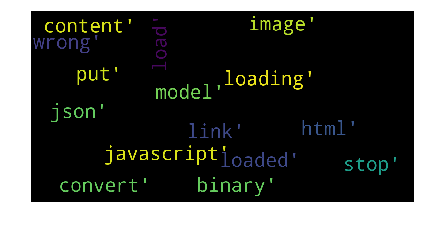


Topic 1
['stream', 'difference', 'interface', 'task', 'method', 'operation', 'behind', 'comment', 'execution', 'mean', 'yes', 'returned', 'produce', 'job', 'exact']


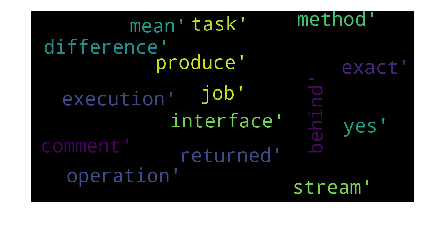


Topic 2
['io', 'device', 'video', 'extension', 'xcode', 'sdk', 'chrome', 'tag', 'entity', 'framework', 'updated', 'instruction', 'core', 'followed', 'website']


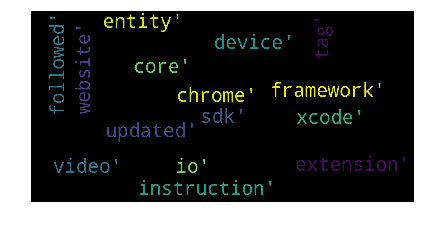


Topic 3
['button', 'text', 'view', 'click', 'select', 'column', 'display', 'layout', 'screen', 'box', 'selected', 'bottom', 'row', 'left', 'top']


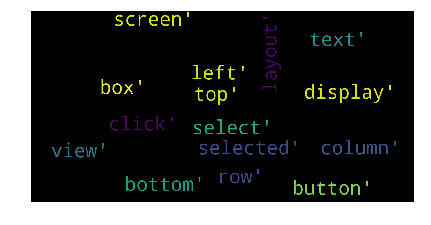


Topic 4
['date', 'format', 'local', 'range', 'linux', 'across', 'came', 'address', 'window', 'shared', 'return', 'please', 'recently', 'machine', 'setting']


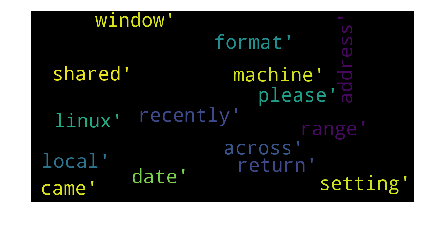


Topic 5
['php', 'lambda', 'remove', 'space', 'false', 'graph', 'true', 'mode', 'number', 'side', 'modify', 'left', 'give', 'giving', 'worked']


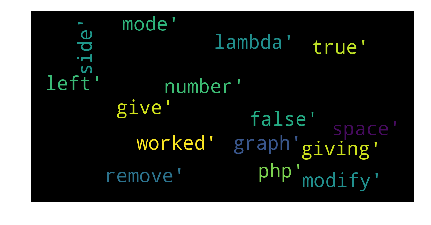


Topic 6
['element', 'vector', 'map', 'key', 'list', 'nested', 'string', 'array', 'sum', 'count', 'condition', 'sort', 'filter', 'integer', 'object']


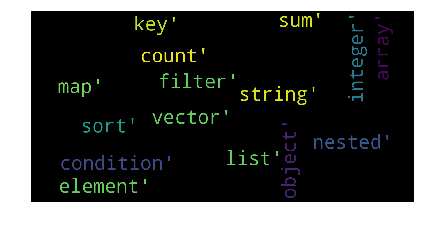


Topic 7
['color', 'cs', 'test', 'unit', 'stack', 'background', 'custom', 'report', 'element', 'effect', 'shown', 'bug', 'behavior', 'look', 'break']


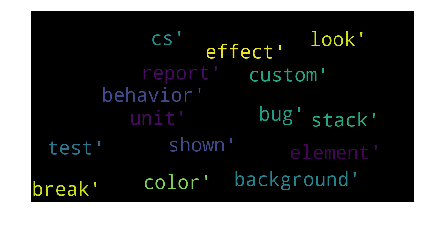


Topic 8
['node', 'expression', 'loop', 'null', 'empty', 'variable', 'explain', 'undefined', 'block', 'snippet', 'resolve', 'return', 'weird', 'twice', 'properly']


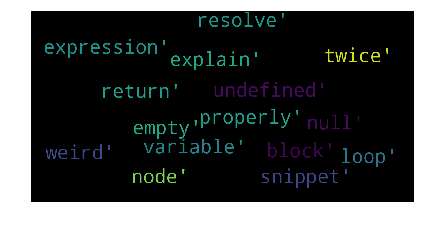


Topic 9
['request', 'service', 'google', 'message', 'url', 'client', 'web', 'http', 'spring', 'access', 'browser', 'connection', 'firebase', 'event', 'header']


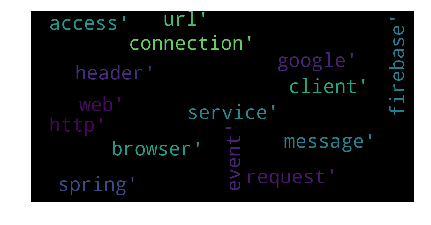


Topic 10
['exception', 'print', 'copy', 'statement', 'character', 'throw', 'extract', 'someone', 'define', 'sometimes', 'language', 'solve', 'changed', 'appreciate', 'give']


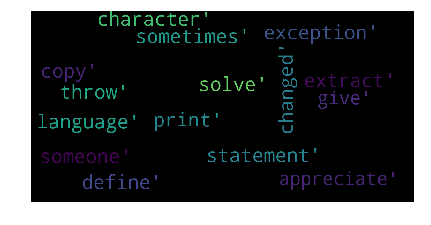


Topic 11
['column', 'memory', 'row', 'dataframe', 'index', 'panda', 'loop', 'performance', 'take', 'dataset', 'large', 'point', 'answer', 'variable', 'second']


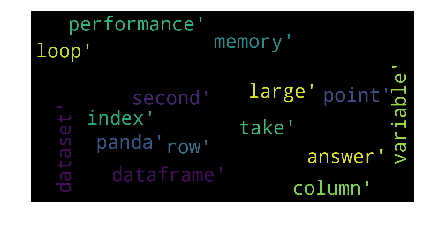


Topic 12
['compiler', 'template', 'parameter', 'constructor', 'member', 'type', 'compile', 'reference', 'gcc', 'std', 'variable', 'argument', 'static', 'standard', 'defined']


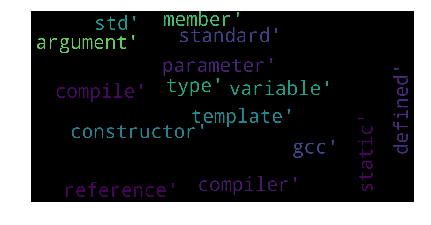


Topic 13
['thread', 'item', 'size', 'line', 'dynamic', 'look', 'position', 'answer', 'entry', 'part', 'right', 'element', 'thing', 'unique', 'point']


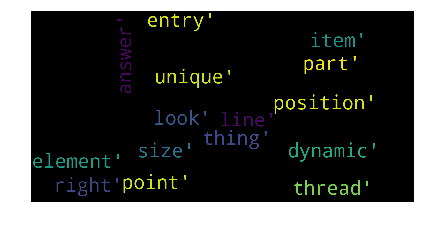


Topic 14
['studio', 'module', 'package', 'library', 'install', 'gradle', 'import', 'dependency', 'visual', 'installed', 'folder', 'command', 'directory', 'failed', 'window']


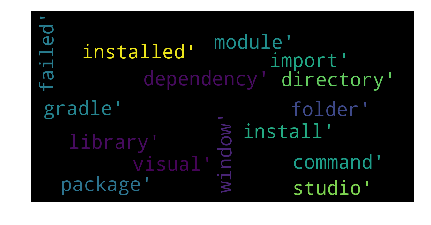


Topic 15
['match', 'syntax', 'pattern', 'word', 'argument', 'pointer', 'tab', 'replace', 'flag', 'matching', 'returning', 'equivalent', 'character', 'location', 'rule']


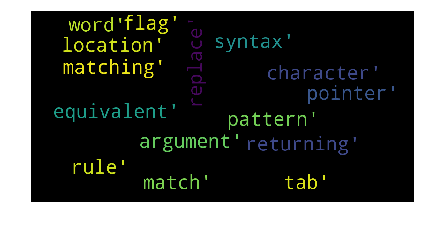


Topic 16
['component', 'react', 'property', 'child', 'native', 'parent', 'attribute', 'state', 'route', 'passing', 'global', 'pas', 'follow', 'view', 'dynamically']


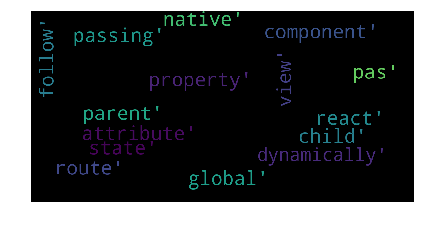


Topic 17
['kotlin', 'group', 'record', 'delete', 'id', 'operator', 'insert', 'db', 'row', 'column', 'piece', 'info', 'receive', 'figure', 'remove']


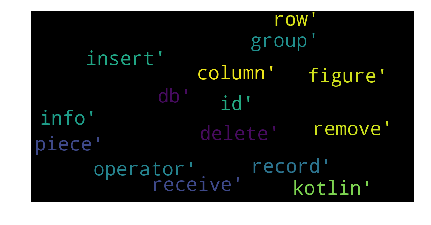


Topic 18
['query', 'sql', 'script', 'command', 'product', 'collection', 'table', 'debug', 'database', 'document', 'execute', 'wrote', 'result', 'statement', 'got']


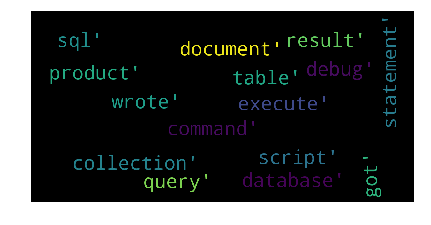


Topic 19
['angular', 'form', 'field', 'input', 'jquery', 'search', 'crash', 'session', 'template', 'action', 'control', 'html', 'user', 'component', 'login']


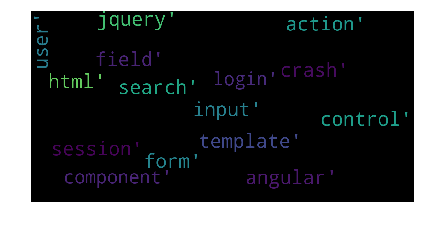

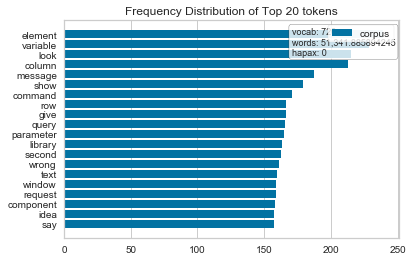

Avec mots
0.7 %
Avec tags
57.5 %


In [16]:
### NON-SUPERVISE
matrixnum_tfidf_train, matrixnum_tfidf_test = non_supervise(new_df, data, liste_tags)

In [17]:
# Sépération des datasets
data_train, data_test = train_test_split(new_df,
                                         test_size=0.25,
                                         random_state=3)

# One hot encoding en prenant en compte la séparation des tags
df_tags = data['Tags'].str.get_dummies(sep=' ')
df_tags_train = data_train['Tags'].str.get_dummies(sep=' ')
df_tags_test = data_test['Tags'].str.get_dummies(sep=' ')

# Réduction de la dimension de la matrice des tags,
# on ne prends que les plus fréquents
mask = pd.Series(df_tags.sum() > 50)
df_tags_train = df_tags_train.loc[:, mask]
df_tags_test = df_tags_test.loc[:, mask]

    Il s’agit de la troisième grande étape avec un test de manière supervisée.

    On utilise l'algorithme RandomForestClassifier qui a fait ses preuves dans le domaine de classification.
    
    Cet algorithme appartient à la famille des agrégations de modèles. Le principe est de faire la moyenne des prévisions de plusieurs modèles indépendants pour réduire la variance et donc l’erreur de prévision. Pour construire ces différents modèles, on sélectionne plusieurs échantillons (tirages avec remises). Pour chaque arbre on sélectionne un échantillon d’individus et à chaque étape, la construction d’un nœud de l’arbre se fait sur un sous-ensemble de variables tirées aléatoirement. On se retrouve donc avec plusieurs arbres et donc des prédictions différentes. Pour obtenir la valeur finale, dans le cas d’une classification, on garde la valeur la plus probable.

    On utilise également la stratégie de classification OneVsRestClassifier. Cette stratégie permet de fiter un classifieur par classe, or nous sommes dans un problème multidimensionnel.
    
    Ensuite, en faisant une prédiction des probabilités, on peut retirer les 5 tags les plus probables parmi ceux existants et les proposer à un nouvel utilisateur pour sa question.

In [18]:
### SUPERVISE
supervise(data, matrixnum_tfidf_train, matrixnum_tfidf_test, df_tags_train, df_tags_test)

RandomForestClassifier_30_10 

Supervisé
61.5 %
How to use Java10 with Eclipse Plugin?If I specify JavaSE-10 as minimum executio ...
Actual label : eclipse eclipse-plugin java-10 
Predicted label : ['java'] 

How to write a function to compute proportion for different combination of numbe ...
Actual label : python python-3.x 
Predicted label : ['python'] 

DataFrame calculating by group for log return of each stockAs an example, I have ...
Actual label : python python-3.x pandas dataframe 
Predicted label : ['dataframe'] 

How to avoid C++ code bloat issued by template instantiation and symbol table?I' ...
Actual label : c++11 templates gcc bare-metal 
Predicted label : ['templates', 'gcc'] 

RandomForestClassifier_None_10 

Supervisé
60.6 %
How to use Java10 with Eclipse Plugin?If I specify JavaSE-10 as minimum executio ...
Actual label : eclipse eclipse-plugin java-10 
Predicted label : ['java'] 

Different accuracy between python keras and keras in RI build a image classifica ...
Ac

# Resultats

* Premier métrique (prediction non supervisée, sans les tags d'origine) : 0,7 %
* Deuxième métrique (prédiction non supervisée, avec les tags d'origine) : 57 %
* Troisième métrique (prédiction superviées) : en moyenne 61 %

# Conclusion

    Les prédictions supervisées sont légèrement meilleures.
    
    Plusieurs critères doivent rentrer en compte :

    L’expérience de l’utilisateur est un critère qui n’a pas été exploité dans ce projet mais qui est important. Les résultats peuvent être différents si on entraine le modèle uniquement sur des utilisateurs expérimentés.

    De plus, les méthodes supervisées et non-supervisées bien que donnant des résultats assez similaires sur l’échantillon étudié (à 10% près, néanmoins), ont chacune leur avantage. Le supervisé va toujours avoir des meilleures performances tant que le non-supervisé permet de créer une liste tag avec des tags qui n’étaient pas là à l’origine). On peut cependant penser que ce dernier avantage n’est pas forcément très important sur Stack Overflow.